In [ ]:
# pip install torch torchvision numpy matplotlib
import torch
import torchvision
from torch import nn
import torch.nn.functional as func
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
trainLoss_plot = []
testLoss_plot = []
trainAcc_plot = []
testAcc_plot = []

In [ ]:
# Train transformation
train_transform = transforms.Compose([
    #transforms,RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])
# Test transformation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.45), (0.5))
])

# Download training data from open datasets.
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=train_transform,
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=test_transform,
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of X [N, C, H, W]:  torch.Size([256, 3, 32, 32])
Shape of y:  torch.Size([256]) torch.int64


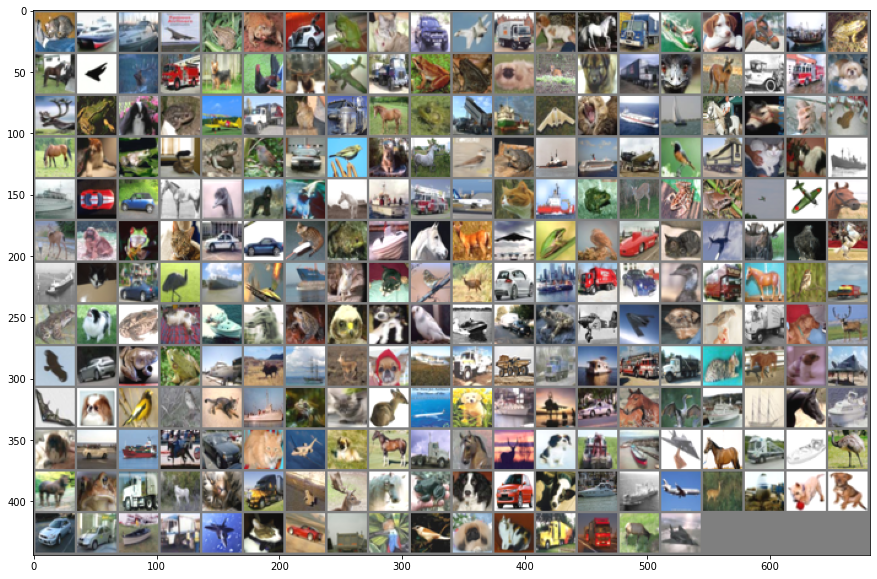

In [ ]:
# Training batch size
batch_size = 256

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Each batch tensor shape
for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    
    imshow(torchvision.utils.make_grid(X, nrow=20))
    
    break

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        '''
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        '''
        self.Conv2d_stack = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(10816, out_features=10)
        )
        

    def forward(self, x):
        # print(x.shape)
        # x = self.flatten(x)
        # print(x.shape)
        #logits = self.linear_relu_stack(x)
        y = self.Conv2d_stack(x)
        return y

model = NeuralNetwork().to(device)
# for X, y in test_dataloader:
#     output = model(X)
#     break
print(model)

Using cuda device
NeuralNetwork(
  (Conv2d_stack): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=10816, out_features=10, bias=True)
  )
)


In [ ]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# SGD Optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4, momentum=0.9)
#scheduler = ExponentialLR(optimizer, gamma=0.9)

In [ ]:
# Training function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    # Turn on training mode
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # record loss
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    #scheduler.step()
    
    train_loss /= len(dataloader)
    correct /= size
    
    print(f" Train accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f}")   
    trainLoss_plot.append(train_loss)
    trainAcc_plot.append(100*correct)

In [ ]:
# Test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    # Turn on evalution mode
    model.eval()
    test_loss, correct = 0, 0
    
    # Turn off gradient descent
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            # record loss
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    
    print(f" Test accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    testLoss_plot.append(test_loss)
    testAcc_plot.append(100*correct)

In [ ]:
# Total training epochs
epochs = 100

for t in range(epochs):
    print('\n', "=" * 15, "Epoch", t + 1, "=" * 15)
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    
print(" Done!")


 =============== Epoch 1 ===============


KeyboardInterrupt: ignored

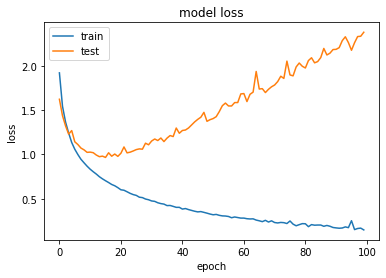

In [ ]:
plt.plot(trainLoss_plot)
plt.plot(testLoss_plot)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


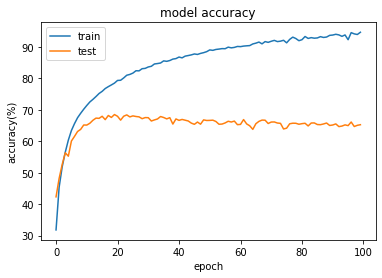

In [ ]:
plt.plot(trainAcc_plot)
plt.plot(testAcc_plot)
plt.title('model accuracy')
plt.ylabel('accuracy(%)')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Saving model weights
# torch.save(model)
torch.save(model.state_dict(), "model.pth")
print(" Saved PyTorch Model State to model.pth")

 Saved PyTorch Model State to model.pth


In [ ]:
# Build the network
model = NeuralNetwork()

# Load trained weights
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [ ]:
# 10 Classes
classes = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]

# Evaluation mode
model.eval()

# Get one sample
x, y = torch.tensor(test_data.data[10]).float().unsqueeze(0), test_data.targets[10]
# print(x.shape)
# x, y = test_data.data[0], test_data.targets[1]

# Turn off gradient descent
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f' Predicted: "{predicted}", Actual: "{actual}"')

 Predicted: "Airplane", Actual: "Airplane"
